# Checking the data
## List raw data contents

In [3]:
import zipfile

In [4]:
data = zipfile.ZipFile(r'../data/raw/1113_XYZ.zip', 'r')

In [5]:
data.printdir()

File Name                                             Modified             Size
1113 - Relatorio Final - Sudeste do Mato Grosso.pdf 2012-09-17 16:05:48     14754917
XYZ/1113_Cruzamentos.XYZ                       2012-07-17 09:36:16     10177163
XYZ/1113_GamaLine.XYZ                          2012-07-04 16:42:34    859936849
XYZ/1113_GamaTie.XYZ                           2012-07-04 16:35:02     45060637
XYZ/1113_MagLine.XYZ                           2012-07-05 11:14:22   6079955329
XYZ/1113_MagTie.XYZ                            2012-07-05 11:00:58    318605838
XYZ/                                           2013-02-15 14:57:30            0


We're interested in XYZ/1113_MagLine.XYZ and XYZ/1113_MagTie.XYZ files. These seem to be raw and processed aeromag data exported from two Geosoft's Oasis montaj database files.

If you can read brazilian portuguese, one interesting file to check is "1113 - Relatorio Final - Sudeste do Mato Grosso.pdf", since it's the final processing report.

## Checking the file headers
Now we're going to list both files header to get a feel of the file format.

In [6]:
n = 15 # number of lines to read

with data.open('XYZ/1113_MagLine.XYZ') as f:
    head = [next(f) for x in range(n)]

# Decode the bytes object into a string object
head = [line.decode("utf-8") for line in head]

print('\n'.join(head))

/ ------------------------------------------------------------------------------

/ XYZ EXPORT [07/05/2012]

/ DATABASE   [.\Disco\GDB\1113_MagLine.gdb]

/ ------------------------------------------------------------------------------

/

/         X          Y FIDUCIAL   GPSALT     BARO   ALTURA      MDT    MAGBASE     MAGBRU     MAGCOM     MAGCOR     MAGNIV     MAGMIC    MAGIGRF       IGRF   LONGITUDE    LATITUDE       DATA       HORA 

/========== ========== ======== ======== ======== ======== ======== ========== ========== ========== ========== ========== ========== ========== ========== =========== =========== ========== ========== 

/

//Flight 307

//Date 2011/08/07

Line  10010

    174673    8506596  10916.0   554.12   482.93    80.54   481.06  23354.887  23800.096  23799.297  23804.534  23804.655  23804.728    127.477  23677.251  -54.004809  -13.490805 2011/08/07 14:15:28.0 

    174673    8506589  10916.1   554.29   483.10    81.02   481.00  23354.887  23800.104  23799.327  

In [7]:
with data.open('XYZ/1113_MagTie.XYZ') as f:
    head = [next(f) for x in range(n)]

# Decode the bytes object into a string object
head = [line.decode("utf-8") for line in head]

print('\n'.join(head))

/ ------------------------------------------------------------------------------

/ XYZ EXPORT [07/05/2012]

/ DATABASE   [.\Disco\GDB\1113_MagTie.gdb]

/ ------------------------------------------------------------------------------

/

/         X          Y FIDUCIAL   GPSALT     BARO   ALTURA      MDT    MAGBASE     MAGBRU     MAGCOM     MAGCOR     MAGNIV     MAGMIC    MAGIGRF       IGRF   LONGITUDE    LATITUDE       DATA       HORA 

/========== ========== ======== ======== ======== ======== ======== ========== ========== ========== ========== ========== ========== ========== ========== =========== =========== ========== ========== 

/

//Flight 5

//Date 2011/07/30

Tie  19010

    607843    8232313   7182.0   839.98   804.58    81.05   757.36  23411.514  23476.831          *  23427.814  23430.721  23433.095     10.258  23422.837  -49.992151  -15.986348 2011/07/30 14:48:29.0 

    607837    8232313   7182.1   840.14   804.64    81.16   757.56  23411.513  23477.055  23478.765  2342

## Plotting flight lines and tie lines

Now the file structure is clear. Both files are divided in flight lines (Tie # and Line #), with every line containing the same fields described in the header.

These files are way too big to read directly with Pandas, because [pandas.read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) has a memory peak several times bigger than the file size. This is due to format checking etc.

So, first we'll write a small function to yield only part of the data as numpy arrays, since numpy.genfromtxt has the [same problem](https://stackoverflow.com/questions/8956832/python-out-of-memory-on-large-csv-file-numpy) of pandas.read_csv. Next we'll plot a simplified version of the flight lines. This simplification is required since the lines have way too many points each.

In [8]:
import numpy as np
from shapely.geometry import LineString

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('ticks')

In [30]:
def iter_func(data, filename, comment='/'):
    # dictionary with line_number: LineString
    flight_lines = {}
    
    with data.open(filename) as f:
        line_number = None
        x = []
        y = []
        for line in f:
            line = line.decode("utf-8")
            
            if line.startswith(comment):
                continue
            
            # Get the line number
            if 'Tie' in line or 'Line' in line:
                if line_number is not None:
                    # This happens when we enter a new line
                    # I'm using a tolerance of 100 m to simplify the line path
                    flight_lines[line_number] = LineString(np.vstack((x,y)).T).simplify(tolerance=100)
                    x = []
                    y = []
                    
                line_number = np.int(line.strip().split()[1])
                continue
                
            # Split the line using \s+ as the pattern and get only X and Y
            line = line.strip().split()[:2]
            x.append(np.float(line[0]))
            y.append(np.float(line[1]))
            
        return flight_lines

In [37]:
# These files are quite big, so they may take a couple minutes to read.
tie_lines =  iter_func(data, 'XYZ/1113_MagTie.XYZ')
flight_lines =  iter_func(data, 'XYZ/1113_MagLine.XYZ')

/home/rodrigo/anaconda3/envs/gravmag/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


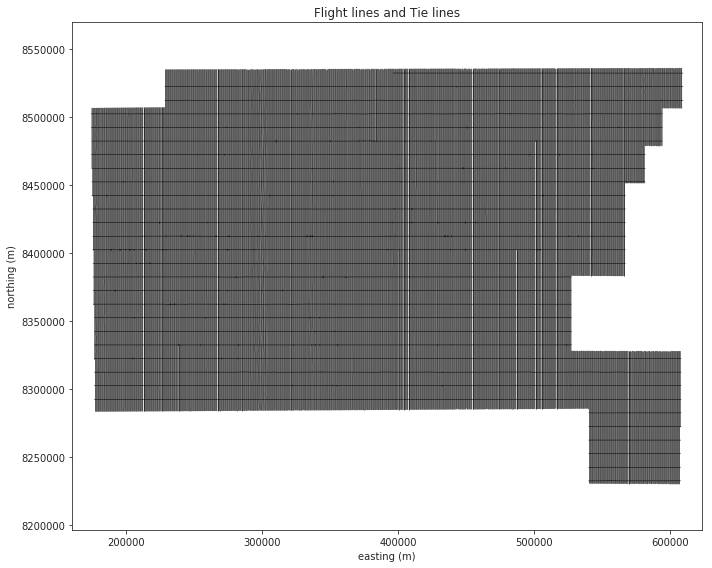

In [48]:
plt.figure(figsize=(10,8))
for l in tie_lines:
    x,y = tie_lines[l].xy
    plt.plot(x,y, 'k', lw=0.5)
    
for l in flight_lines:
    x,y = flight_lines[l].xy
    plt.plot(x,y, 'k', lw=0.5)

plt.axes().set_aspect('equal', 'datalim')
plt.title('Flight lines and Tie lines')
plt.xlabel('easting (m)')
plt.ylabel('northing (m)')
plt.tight_layout()

Figure 1 - Flight and Tie lines for the aeromagnetometric survey. Projection UTM 22S/WGS 84 (EPSG:32722).

In [49]:
data.close()